In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn import svm
from scipy import stats
import numpy as np
import network_dataloader as ndl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Get pretrained model

In [2]:
net = models.vgg16(pretrained=True, progress=True).to(device=device)

## Modify the last layer to output the same as input

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
net.classifier[6] = Identity()

## Get dataset

In [4]:
batchSize = 56
input_size = 224
# Load Data
data_transforms = {
        'train': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()]), 
        'test': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()])
        }

print("Initializing Datasets and Dataloaders...")

# Create training and testing datasets
image_datasets = {x: ndl.TopoplotLoader('images', x, data_transforms[x]) for x in ['train', 'test']}

# Create training and testing dataloaders
dataloaders_dict = {'train': Data.DataLoader(image_datasets['train'], batch_size=batchSize, shuffle=True, num_workers=4),
                    'test':  Data.DataLoader(image_datasets['test'], batch_size=batchSize, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
> Found 56 images...
> Found 7 images...


## Extract features by VGG16 

In [5]:
net.eval() # Disable batchnorm, dropout

# Training data
for samples in dataloaders_dict['train']:
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    with torch.no_grad():
        X_train = net(imgs).cpu().numpy()
    Y_train = labels.cpu().numpy()
    
print('X_train shape : ', X_train.shape)
print('Y_train shape : ', Y_train.shape)
    
# Testing data
for samples in dataloaders_dict['test']:
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    with torch.no_grad():
        X_test = net(imgs).cpu().numpy()
    Y_test = labels.cpu().numpy()
    
print('X_test shape : ', X_test.shape)
print('Y_test shape : ', Y_test.shape)
    


X_train shape :  (56, 4096)
Y_train shape :  (56,)
X_test shape :  (7, 4096)
Y_test shape :  (7,)


## Apply PCA to reduct dimension

In [22]:
pca = PCA(n_components=10)
pca.fit(X_train)

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

print('X_train_PCA shape : ', X_train_PCA.shape)
print('X_test_PCA shape : ', X_test_PCA.shape)

X_train_PCA shape :  (56, 10)
X_test_PCA shape :  (7, 10)


## Regression to predict solution time

In [40]:
X_train_Reg = X_train_PCA
X_test_Reg = X_test_PCA
clf = linear_model.Lasso(alpha=1)
clf.fit(X_train_Reg, Y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

Average difference of training data:  13.567637852260043
DescribeResult(nobs=56, minmax=(2.4296875, 82.87891), mean=19.08531, variance=379.44598, skewness=1.5871025323867798, kurtosis=1.858187245913383)


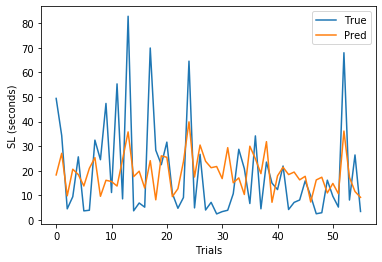

In [41]:
num_train = len(Y_train)
pred_train = clf.predict(X_train_Reg).flatten()
plt.plot(range(num_train), Y_train)
plt.plot(range(num_train), pred_train)
plt.xlabel('Trials')
plt.ylabel('SL (seconds)')
plt.legend(('True', 'Pred'))

MSE_train = 1/num_train * np.sum(np.abs(pred_train-Y_train))
print('Average difference of training data: ', MSE_train)
print(stats.describe(Y_train))

Average difference of testing data:  11.424543108258929
DescribeResult(nobs=7, minmax=(4.1132812, 30.390625), mean=12.50558, variance=123.50408, skewness=0.9258143901824951, kurtosis=-1.024864569632204)


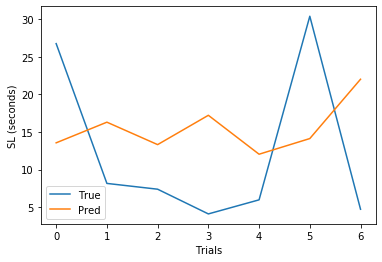

In [42]:
num_test = len(Y_test)
pred_test = clf.predict(X_test_Reg).flatten()
plt.plot(range(len(Y_test)), Y_test)
plt.plot(range(len(Y_test)), pred_test)
plt.xlabel('Trials')
plt.ylabel('SL (seconds)')
plt.legend(('True', 'Pred'))

MSE_test = 1/num_test * np.sum(np.abs(pred_test-Y_test))
print('Average difference of testing data: ', MSE_test)
print(stats.describe(Y_test))

## Binary classification

In [6]:
Y_train_Cla = Y_train
Y_test_Cla = Y_test

In [7]:
Y_train_Cla[Y_train<=30] = 0
Y_train_Cla[Y_train>30] = 1
Y_test_Cla[Y_test<=30] = 0
Y_test_Cla[Y_test>30] = 1 

In [8]:
clf = svm.SVC()
clf.fit(X_train, Y_train_Cla)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
num_train = len(Y_train)
pred_train = clf.predict(X_train)

print('Training : (%d, %d)'%(np.sum(pred_train == Y_train_Cla), num_train))
print('Accuracy : %f'%(np.sum(pred_train == Y_train_Cla)/num_train*100))

num_test = len(Y_test)
pred_test = clf.predict(X_test)

print('Testing : (%d, %d)'%(np.sum(pred_test == Y_test_Cla), num_test))
print('Accuracy : %f'%(np.sum(pred_test == Y_test_Cla)/num_test*100))

Training : (45, 56)
Accuracy : 80.357143
Testing : (6, 7)
Accuracy : 85.714286
